In [8]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import sklearn.datasets as skdata
import os
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

In [9]:
def predict(x, *, clfs, coefs):
    return np.array([
        k * clf.predict(x)
        for k, clf in zip(coefs, clfs)
    ]).sum(axis=0)


def fit(x, y, *, clfs, coefs):
    clf_initial, *clfs = clfs    
    fitted_clfs = [clf_initial.fit(x, y)]
    for clf in clfs:
        errors = y - predict(x, clfs=fitted_clfs, coefs=coefs)
        fitted_clfs.append(clf.fit(x, errors))
    return fitted_clfs


class SimpleGradientBoostingRegressor:

    def __init__(self, *, n_estimators, learning_rates, max_depth, random_state):
        self.n_estimators = n_estimators
        self.learning_rates = learning_rates
        self.max_depth = max_depth
        self.random_state = random_state
        self.learning_rates = learning_rates        
        self.classifiers = [
            DecisionTreeRegressor(
                max_depth=self.max_depth, random_state=self.random_state)
            for _ in range(self.n_estimators)
        ]
        
    def fit(self, x, y):
        return fit(x, y, clfs=self.classifiers, coefs=self.learning_rates)
    
    def predict(self, x):
        return predict(x, clfs=self.classifiers, coefs=self.learning_rates)

In [12]:
DATA_DIR = 'data'

def get_ads(data_dir=DATA_DIR):
    ads = []
    for data_filename in os.listdir(data_dir):
        path = os.path.join(data_dir, data_filename)
        with open(path) as data_file:
            raw = json.load(data_file)
            ads += [json.loads(ad) for ad in raw]
    return pd.DataFrame(ads)

ads = get_ads()

In [14]:
X = ads[['category' == 1010]].values
Y = ads['price'].values
print(X.shape)

train_x, train_y, test_x, test_y = train_test_split(X, Y)

(8498, 9)


In [6]:
N_CLFS = 50
coefs = np.array([0.9 for _ in range(N_CLFS)])

sgbr = SimpleGradientBoostingRegressor(
    n_estimators=N_CLFS, 
    learning_rates=coefs, 
    max_depth=5,
    random_state=42)

sgbr.fit(x_train, y_train)

mse_test = mean_squared_error(
    y_test,
    sgbr.predict(x_test))
print(mse_test)

17.737997705962755


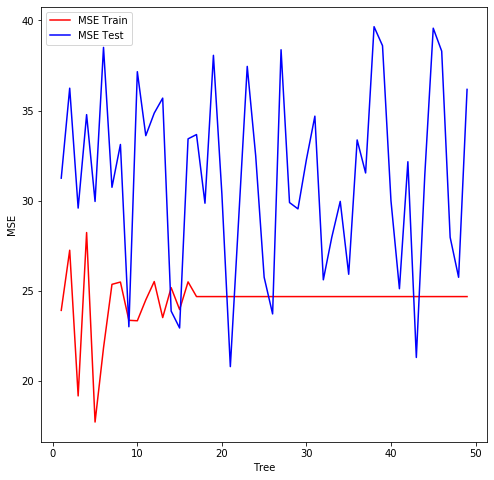

In [38]:
niters = np.arange(1, 50)
mse_trains = []
mse_tests = []

for niter in niters:
    coefs = np.array([0.9 / (i+1)  for i in range(niter)])
    sgbr = SimpleGradientBoostingRegressor(
        n_estimators=niter, 
        learning_rates=coefs, 
        max_depth=5,
        random_state=42)
    sgbr.fit(x_train, y_train)
    
    mse_test = mean_squared_error(
        y_test, sgbr.predict(x_test))
    mse_tests.append(mse_test)
    
    mse_train = mean_squared_error(
        y_train, sgbr.predict(x_train))
    mse_trains.append(mse_train)
    
    
_, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(niters, mse_trains, c='red', label='MSE Train')
ax.plot(niters, np.array(mse_tests), c='blue', label='MSE Test')
ax.set_xlabel('Tree')
ax.set_ylabel('MSE')
ax.legend()